# Imports

In [ ]:
from __future__ import print_function

import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adadelta, Adagrad, Adam, Nadam, SGD
from keras.callbacks import EarlyStopping, TerminateOnNaN
from keras import backend as K
from keras.losses import mean_squared_error
from keras.models import load_model, Model
import tensorflow as tf

# Normalize the data.
from sklearn import preprocessing
from keras.regularizers import l1_l2

import random

def pass_arg(Xx, nsim, tr_size):
    print("Tr_size:", tr_size)
    def fix_seeds(seed):
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
        session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
        sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
    #     K.set_session(sess)
        tf.compat.v1.keras.backend.set_session(sess)

    ss = 1
    fix_seeds(ss)

    # MC dropout
    class MCDropout(Dropout):
        def call(self, inputs, training=None):
            return super(MCDropout, self).call(inputs, training=True)


    # import pickle

    # def save_obj(obj, name):
    #     with open(name, 'wb') as f:
    #         pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

    # Compute the RMSE given the ground truth (y_true) and the predictions(y_pred)
    def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

    # # Making sure dimensionless bond length is less than 1
    # def bond(bl):
    #     return bl-1.0

    # Making sure dimensionless bond length is less than 1
    def bond(bl):
        bln = -bl*(bl<0)
        blp = bl*(bl>=1.0) - 1*(bl>=1.0)
        return bln+blp

    # # Making sure final porosity is less than initial
    # def poros(poroi, porof):
    # #     porof[porof < 0] = 1-porof[porof < 0]
    #     porof[porof < 0] = poroi[0]-porof[porof < 0]
    #     print(porof)
    #     return porof-poroi

    # Making sure final porosity is less than initial
    def poros(poroi, porof):
        porofn = -porof*(porof<0)
        porofp = porof*(porof>=poroi) - poroi*(porof>=poroi)
        return porofp+porofn

    def strength1(bl, porof, nlayer=6):
        sigma01, sigma02 = 6, 31
        C1s = 21
        sigma_long = sigma01*(np.exp((1.0-porof)**(C1s*nlayer))-porof) + sigma02*(1.0-porof)
        sigma_long_sorted = np.sort(sigma_long, axis=-1)  # sorts along first axis (down)
        ind = np.argsort(sigma_long, axis=-1)  # sorts along first axis (down)
        bl_sorted = np.take_along_axis(bl, ind, axis=-1)  # same as np.sort(x, axis=0)
        corr_bl_sorted = np.sort(bl, axis=-1)  # sorts along first axis (down)
        return corr_bl_sorted-bl_sorted

    def strength2(bl, porof, nlayer=6):
        sigma01, sigma02 = 6, 31
        C1s = 21
        sigma_long = sigma01*(np.exp((1.0-porof)**(C1s*nlayer))-porof) + sigma02*(1.0-porof)
        sigma_long_sorted = np.sort(sigma_long, axis=-1)  # sorts along first axis (down)
        ind = np.argsort(sigma_long, axis=-1)  # sorts along first axis (down)
        bl_sorted = np.take_along_axis(bl, ind, axis=-1)  # same as np.sort(x, axis=0)
        return sum(bl_sorted[1:]-bl_sorted[:-1]<0)/14

    def phy_loss_mean(params):
        # useful for cross-checking training
        loss1, loss2, loss3, loss4, lam1, lam2 = params
        x1, x2, x3 = loss1*(loss1>0), loss2*(loss2>0), loss3*(loss3>0)

        if x1.any() and x1.shape[0]>1:
            X_scaled1 = (x1 - np.min(x1)) / (np.max(x1) - np.min(x1))
            x1 = X_scaled1
        if x2.any() and x2.shape[0]>1:
            X_scaled2 = (x2 - np.min(x2)) / (np.max(x2) - np.min(x2))
            x2 = X_scaled2
        if x3.any() and x3.shape[0]>1:
            X_scaled3 = (x3 - np.min(x3)) / (np.max(x3) - np.min(x3))
            x3 = X_scaled3
        return (lam1*np.mean(x1) + lam2*np.mean(x2) + lam2*np.mean(x3))
    #     return (lam1*np.mean(x1) + lam2*np.mean(x2) + lam2*np.mean(x3) + lam2*loss4)

    def PGNN_train_test(optimizer_name, optimizer_val, pre_train, tr_size, lamda, iteration, n_nodes, n_layers, drop_frac, reg, samp):

        # Hyper-parameters of the training process
    #     batch_size = int(tr_size/2)
        batch_size = 1
        num_epochs = 50
        val_frac = 0.5
        patience_val = 50

        # Initializing results filename
        exp_name = "DNN_pre_hyb_" + pre_train + optimizer_name + '_trsize' + str(tr_size) + '_lamda' + str(lamda) + '_iter' + str(iteration)
        exp_name = exp_name.replace('.','pt')
        results_dir = '../results/'
        model_name = results_dir + exp_name + '_NoPhyInfomodel.h5' # storing the trained model
        if reg==True and samp==25:
            results_name = results_dir + exp_name + '_results_25_regularizer.dat' # storing the results of the model
        elif reg==False and samp==25:
            results_name = results_dir + exp_name + '_results_25.dat' # storing the results of the model
        elif reg==True and samp==1519:
            results_name = results_dir + exp_name + '_results_1519_regularizer.dat' # storing the results of the model
        elif reg==False and samp==1519:
            results_name = results_dir + exp_name + '_results_1519.dat' # storing the results of the model
        
        # Load labeled data
        data = np.loadtxt('../data/labeled_data.dat')
        x_label = data[:, :-3] # -2 because we do not need porosity predictions
        x_labeled = np.hstack((x_label[:,:2],x_label[:,-2:]))
        y_labeled = data[:, -3:-1]

#         if samp==25:
#             data2 = np.loadtxt('../data/unlabeled_data_BK_constw_v2_25.dat')
#             x_unlabeled = data2[:, :]
#         elif samp==1519:
#             data2 = np.loadtxt('../data/unlabeled_data_BK_constw_v2_1525.dat')

#         data1 = data2[:1303, :]
#         data2 = data2[-6:, :]
#         datah = np.vstack((data1,data2))
# #         np.random.shuffle(datah)
#         x_labeled = np.hstack((datah[:, :2],datah[:,-3:-1]))
# #         x_unlabeled = datah[:, :2] # 1303 last regular sample
#         y_unlabeled = datah[:, -3:-1]
        
        # normalize dataset with MinMaxScaler
        scaler = preprocessing.MinMaxScaler(feature_range=(0, 1.0))
    #     scaler = preprocessing.StandardScaler()
        x_labeled = scaler.fit_transform(x_labeled)
        y_labeled = scaler.fit_transform(y_labeled)

        # train and test data
        trainX, trainY = x_labeled[:tr_size,:], y_labeled[:tr_size]
    #     testX, testY = x_labeled[tr_size:,:], y_labeled[tr_size:]
    #     init_poro = data[tr_size:, -1]
        testX, testY = x_labeled[tr_size:,:], y_labeled[tr_size:]
        init_poro = data[tr_size:, -1]

        dependencies = {
         'root_mean_squared_error': root_mean_squared_error
            }

        # load the pre-trained model using non-calibrated physics-based model predictions (./data/unlabeled.dat)
        loaded_model = load_model(results_dir + pre_train, custom_objects=dependencies)
    
        # Creating the model
        model = Sequential()
        for layer in np.arange(n_layers):
            if layer == 0:
                model.add(Dense(n_nodes, activation='relu', input_shape=(np.shape(trainX)[1],)))
            else:
                if reg:
                    model.add(Dense(n_nodes, activation='relu', kernel_regularizer=l1_l2(l1=.001, l2=.001)))
                else:
                    model.add(Dense(n_nodes, activation='relu'))
            # model.add(Dropout(rate=drop_frac))
            model.add(MCDropout(rate=drop_frac))
        model.add(Dense(2, activation='linear'))

        # pass the weights to all layers but 1st input layer, whose dimensions are updated
        for new_layer, layer in zip(model.layers[1:], loaded_model.layers[1:]):
            new_layer.set_weights(layer.get_weights())


        model.compile(loss='mean_squared_error',
                      optimizer=optimizer_val,
                      metrics=[root_mean_squared_error])

        early_stopping = EarlyStopping(monitor='val_loss', patience=patience_val,verbose=1)

        print('Running...' + optimizer_name)
        history = model.fit(trainX, trainY,
                            batch_size=batch_size,
                            epochs=num_epochs,
                            verbose=0,
                            validation_split=val_frac, callbacks=[early_stopping, TerminateOnNaN()])

        test_score = model.evaluate(testX, testY, verbose=1)
        print(test_score)
        # predictions = model.predict(testX)
    # #     inv_pred = scaler.inverse_transform(predictions)
        # phyloss1 = bond(predictions[:,0]) # physics loss 1

    # #     init_poro_ndim = np.ones((init_poro.shape))
    # #     diff2 = poros(init_poro_ndim, predictions[:,1]) # physics loss 2

        # phyloss2 = poros(init_poro, predictions[:,1]) # physics loss 2
        # phyloss3 = strength1(predictions[:,0], predictions[:,1])
        # phyloss4 = strength2(predictions[:,0], predictions[:,1])

        # lam1, lam2 = lamda[0], lamda[1]    
        # phyloss = phy_loss_mean([phyloss1, phyloss2, phyloss3, phyloss4, lam1, lam2])

        # print('iter: ' + str(iteration) + 
              # ' nL: ' + str(n_layers) + ' nN: ' + str(n_nodes) + 
              # ' trsize: ' + str(tr_size) + 
              # ' TestRMSE: ' + str(test_score[1]) + ' PhyLoss: ' + str(phyloss), "\n")

    # #     model.save(model_name)

        # # save results
        # results = {'train_rmse':history.history['root_mean_squared_error'], 
                                    # 'val_rmse':history.history['val_root_mean_squared_error'],
                                    # 'test_rmse':test_score[1], 'PhyLoss':phyloss}

    #     save_obj(results, results_name)

        # return results, results_name, predictions, testY, test_score[1]
        # predictions = model.predict(Xx)

        samples = []
        for i in range(int(nsim)):
            print("simulation num:",i)
            predictions = model.predict(Xx)
            predictions = predictions[:,1]
            samples.append(predictions)
        return np.array(samples)



    # Main Function
    if __name__ == '__main__':

        fix_seeds(1)

        # List of optimizers to choose from    
        optimizer_names = ['Adagrad', 'Adadelta', 'Adam', 'Nadam', 'RMSprop', 'SGD', 'NSGD']
        optimizer_vals = [Adagrad(clipnorm=1), Adadelta(clipnorm=1), Adam(clipnorm=1), Nadam(clipnorm=1), RMSprop(clipnorm=1), SGD(clipnorm=1.), SGD(clipnorm=1, nesterov=True)]

        # selecting the optimizer
        optimizer_num = 1
        optimizer_name = optimizer_names[optimizer_num]
        optimizer_val = optimizer_vals[optimizer_num]

        # Selecting Other Hyper-parameters
        drop_frac = 0.1 # Fraction of nodes to be dropped out
        n_layers = 2 # Number of hidden layers
        n_nodes = 5 # Number of nodes per hidden layer

        # # Iterating over different training fractions and splitting indices for train-test splits
        # trsize_range = [4,6,8,10,20]

        # #default training size = 5000
        # tr_size = trsize_range[4]

        # pre-trained model
        pre_train = 'Pre-trainAdadelta_drop0_nL2_nN10_trsize1308_iter0.h5'

        tr_size = int(tr_size)

        # use regularizer
        reg = True

        # sample size used
        samp = 1519

        #set lamda=0 for pgnn0
        lamda = [1, 1] # Physics-based regularization constant

        # total number of runs
        iter_range = np.arange(1)
        testrmse=[]
        # iterating through all possible params
        for iteration in iter_range:
            # results, result_file, pred, obs, rmse = PGNN_train_test(optimizer_name, optimizer_val, drop_rate, 
                            # iteration, n_layers, n_nodes, tr_size, lamda, reg)
            # testrmse.append(rmse)
            pred = PGNN_train_test(optimizer_name, optimizer_val, 
                                               pre_train, tr_size, lamda, iteration, n_nodes, n_layers, drop_frac, reg, samp)
    
    return np.squeeze(pred)


In [1]:
from __future__ import print_function

import numpy as np
from keras.models import Sequential
from keras.layers import InputLayer
from keras.layers import Dense, Dropout
# from keras.layers import Dense
# from tensorflow.keras.layers import Dropout, Dense
from keras.optimizers import RMSprop, Adadelta, Adagrad, Adam, Nadam, SGD
from keras.callbacks import EarlyStopping, TerminateOnNaN
from keras import backend as K
import keras
from keras.losses import mean_squared_error
# from keras import Input as Input
import tensorflow as tf

# Normalize the data.
from sklearn import preprocessing
from keras.regularizers import l1_l2

import random

def fix_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
    sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
#     K.set_session(sess)
    tf.compat.v1.keras.backend.set_session(sess)
    
ss = 1
fix_seeds(ss)

Using TensorFlow backend.


# Functions

In [10]:
import pickle

def save_obj(obj, name):
    with open(name, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

        
# def dropout(X, rate=0.5, mc=False):
#     if mc:
#         return tf.keras.layers.Dropout(rate)(X, training=True)
#     else:
#         return tf.keras.layers.Dropout(rate)(X)
    
class MCDropout(Dropout):
    def call(self, inputs, training=None):
        return super(MCDropout, self).call(inputs, training=True)
    
    
# # class MCDropout(tf.keras.layers.Layer):
# class MCDropout(keras.layers):
#     def __init__(self, rate):
#         super(MCDropout, self).__init__()
#         self.rate = rate

#     def call(self, inputs):
#         return Dropout(inputs, rate=self.rate)
    
# Compute the RMSE given the ground truth (y_true) and the predictions(y_pred)
def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

# # Making sure dimensionless bond length is less than 1
# def bond(bl):
#     return bl-1.0

# Making sure dimensionless bond length is less than 1
def bond(bl):
    bln = -bl*(bl<0)
    blp = bl*(bl>=1.0) - 1*(bl>=1.0)
    return bln+blp

# # Making sure final porosity is less than initial
# def poros(poroi, porof):
# #     porof[porof < 0] = 1-porof[porof < 0]
#     porof[porof < 0] = poroi[0]-porof[porof < 0]
#     print(porof)
#     return porof-poroi

# Making sure final porosity is less than initial
def poros(poroi, porof):
    porofn = -porof*(porof<0)
    porofp = porof*(porof>=poroi) - poroi*(porof>=poroi)
    return porofp+porofn

# def strength(bl, porof, nlayer=6):
#     discp = []
#     sigma01, sigma02 = 6, 31
#     C1s = 21
#     sigma_long = sigma01*(np.exp((1.0-porof)**(C1s*nlayer))-porof) + sigma02*(1.0-porof)
# #     print("sigma_long:",sigma_long)
#     for i in range(len(sigma_long)):
#         for j in range(i + 1, len(sigma_long)):
#             if (sigma_long[j] > sigma_long[i]):
#                 discp.append(bl[i] - bl[j])
#     discp = np.array(discp)
#     print(discp)
#     return discp

def strength1(bl, porof, nlayer=6):
    sigma01, sigma02 = 6, 31
    C1s = 21
    sigma_long = sigma01*(np.exp((1.0-porof)**(C1s*nlayer))-porof) + sigma02*(1.0-porof)
    sigma_long_sorted = np.sort(sigma_long, axis=-1)  # sorts along first axis (down)
    ind = np.argsort(sigma_long, axis=-1)  # sorts along first axis (down)
    bl_sorted = np.take_along_axis(bl, ind, axis=-1)  # same as np.sort(x, axis=0)
    corr_bl_sorted = np.sort(bl, axis=-1)  # sorts along first axis (down)
    return corr_bl_sorted-bl_sorted

def strength2(bl, porof, nlayer=6):
    sigma01, sigma02 = 6, 31
    C1s = 21
    sigma_long = sigma01*(np.exp((1.0-porof)**(C1s*nlayer))-porof) + sigma02*(1.0-porof)
    sigma_long_sorted = np.sort(sigma_long, axis=-1)  # sorts along first axis (down)
    ind = np.argsort(sigma_long, axis=-1)  # sorts along first axis (down)
    bl_sorted = np.take_along_axis(bl, ind, axis=-1)  # same as np.sort(x, axis=0)
    return sum(bl_sorted[1:]-bl_sorted[:-1]<0)/14

def phy_loss_mean(params):
    # useful for cross-checking training
    loss1, loss2, loss3, loss4, lam1, lam2 = params
    x1, x2, x3 = loss1*(loss1>0), loss2*(loss2>0), loss3*(loss3>0)
#     print(np.mean(x1), x1.shape[0])
#     print(np.mean(x2), x2.shape[0])
#     print(np.mean(x3), x3.shape[0])
    
    if x1.any() and x1.shape[0]>1:
        X_scaled1 = (x1 - np.min(x1)) / (np.max(x1) - np.min(x1))
        x1 = X_scaled1
    if x2.any() and x2.shape[0]>1:
        X_scaled2 = (x2 - np.min(x2)) / (np.max(x2) - np.min(x2))
        x2 = X_scaled2
    if x3.any() and x3.shape[0]>1:
        X_scaled3 = (x3 - np.min(x3)) / (np.max(x3) - np.min(x3))
        x3 = X_scaled3
    return (lam1*np.mean(x1) + lam2*np.mean(x2) + lam2*np.mean(x3))
#     return (lam1*np.mean(x1) + lam2*np.mean(x2) + lam2*np.mean(x3) + lam2*loss4)

# def phy_loss_mean(params):
#     # useful for cross-checking training
#     diff1, diff2, lam1, lam2 = params
#     x1, x2 = diff1*(diff1>0), diff2*(diff2>0)
#     if np.any(x1):
#         X_scaled1 = (x1 - np.min(x1)) / (np.max(x1) - np.min(x1))
#         x1 = X_scaled1
#     if np.any(x2):
#         X_scaled2 = (x2 - np.min(x2)) / (np.max(x2) - np.min(x2))
#         x2 = X_scaled2
#     return lam1*np.mean(x1) + lam2*np.mean(x2)

def PGNN_train_test(optimizer_name, optimizer_val, drop_rate, iteration, n_layers, n_nodes, tr_size, lamda, reg):
        
    # Hyper-parameters of the training process
#     batch_size = int(tr_size/2)
    batch_size = 1
    num_epochs = 50
    val_frac = 0.5
    patience_val = 50
    
    # Initializing results filename
    exp_name = optimizer_name + '_drop' + str(drop_rate) + '_nL' + str(n_layers) + '_nN' + str(n_nodes) + '_trsize' + str(tr_size) + '_iter' + str(iteration)
    exp_name = exp_name.replace('.','pt')
    results_dir = '../results/'
    model_name = results_dir + exp_name + '_NoPhyInfomodel.h5' # storing the trained model
    if reg:
        results_name = results_dir + exp_name + '_results_regularizer.dat' # storing the results of the model
    else:
        results_name = results_dir + exp_name + '_results.dat' # storing the results of the model
    
    # Load labeled data
    data = np.loadtxt('../data/labeled_data.dat')
#     data = np.loadtxt('../data/labeled_data_BK_constw_unique.dat')
#     data = np.loadtxt('../data/labeled_data_BK_constw_v2.dat')
    x_labeled = data[:, :-5] # -2 because we do not need porosity predictions
    y_labeled = data[:, -3:-1]

    # normalize dataset with MinMaxScaler
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1.0))
#     scaler = preprocessing.StandardScaler()
    x_labeled = scaler.fit_transform(x_labeled)
    y_labeled = scaler.fit_transform(y_labeled)
    
    # train and test data
    trainX, trainY = x_labeled[:tr_size,:], y_labeled[:tr_size]
#     testX, testY = x_labeled[tr_size:,:], y_labeled[tr_size:]
#     init_poro = data[tr_size:, -1]
    testX, testY = x_labeled[20:,:], y_labeled[20:]
    init_poro = data[20:, -1]
    
    # Creating the model
    model = Sequential()
    model.add(InputLayer(input_shape=(np.shape(trainX)[1],)))
#     model = tf.keras.Sequential()
    for layer in np.arange(n_layers):
        if layer == 0:
            model.add(Dense(n_nodes, activation='relu', input_shape=(np.shape(trainX)[1],)))
        else:
            if reg:
                model.add(Dense(n_nodes, activation='relu', kernel_regularizer=l1_l2(l1=.001, l2=.001)))
            else:
                model.add(Dense(n_nodes, activation='relu'))
#         inputs = Input(shape=(np.shape(trainX)[1],))
        model.add(Dropout(rate=drop_rate))
#         model.add(MCDropout(rate=drop_rate))
#         model = dropout(model, rate=drop_rate, mc=True)
    model.add(Dense(2, activation='linear'))

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer_val,
                  metrics=[root_mean_squared_error])
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience_val,verbose=1)
    
    print('Running...' + optimizer_name)
    history = model.fit(trainX, trainY,
                        batch_size=batch_size,
                        epochs=num_epochs,
                        verbose=0,
                        validation_split=val_frac, callbacks=[early_stopping, TerminateOnNaN()])

    test_score = model.evaluate(testX, testY, verbose=1)
    
    # mc dropout predictions
    mc_predictions = []
    for i in range(5):
        y_p = model.predict(testX)
        mc_predictions.append(y_p)
    
    predictions = model.predict(testX)
#     inv_pred = scaler.inverse_transform(predictions)
    phyloss1 = bond(predictions[:,0]) # physics loss 1
    
#     init_poro_ndim = np.ones((init_poro.shape))
#     diff2 = poros(init_poro_ndim, predictions[:,1]) # physics loss 2
    
    phyloss2 = poros(init_poro, predictions[:,1]) # physics loss 2
    phyloss3 = strength1(predictions[:,0], predictions[:,1])
    phyloss4 = strength2(predictions[:,0], predictions[:,1])
    
    lam1, lam2 = lamda[0], lamda[1]    
    phyloss = phy_loss_mean([phyloss1, phyloss2, phyloss3, phyloss4, lam1, lam2])
    
    print('iter: ' + str(iteration) + 
          ' nL: ' + str(n_layers) + ' nN: ' + str(n_nodes) + 
          ' trsize: ' + str(tr_size) + 
          ' TestRMSE: ' + str(test_score[1]) + ' PhyLoss: ' + str(phyloss), "\n")
    
#     model.save(model_name)
    
    # save results
    results = {'train_rmse':history.history['root_mean_squared_error'], 
                                'val_rmse':history.history['val_root_mean_squared_error'],
                                'test_rmse':test_score[1], 'PhyLoss':phyloss}

#     save_obj(results, results_name)
    
    return results, results_name, predictions, testY, test_score[1], mc_predictions

In [16]:
# Main Function
if __name__ == '__main__':
    
    fix_seeds(1)
    
    # List of optimizers to choose from    
    optimizer_names = ['Adagrad', 'Adadelta', 'Adam', 'Nadam', 'RMSprop', 'SGD', 'NSGD']
    optimizer_vals = [Adagrad(clipnorm=1), Adadelta(clipnorm=1), Adam(clipnorm=1), Nadam(clipnorm=1), RMSprop(clipnorm=1), SGD(clipnorm=1.), SGD(clipnorm=1, nesterov=True)]
    
    # selecting the optimizer
    optimizer_num = 1
    optimizer_name = optimizer_names[optimizer_num]
    optimizer_val = optimizer_vals[optimizer_num]
    
    # Selecting Other Hyper-parameters
    drop_rate = 0 # Fraction of nodes to be dropped out
    n_layers = 2 # Number of hidden layers
    n_nodes = 5 # Number of nodes per hidden layer

    # Iterating over different training fractions and splitting indices for train-test splits
    trsize_range = [4,6,8,10,20]
    
    #default training size = 5000
    tr_size = trsize_range[4]
    
    # use regularizer
    reg = True
    
    #set lamda=0 for pgnn0
    lamda = [1, 1] # Physics-based regularization constant
    
    # total number of runs
    iter_range = np.arange(1)
    testrmse=[]
    # iterating through all possible params
    for iteration in iter_range:
        results, result_file, pred, obs, rmse,mc_predictions = PGNN_train_test(optimizer_name, optimizer_val, drop_rate, 
                        iteration, n_layers, n_nodes, tr_size, lamda, reg)
        testrmse.append(rmse)

Running...Adadelta
19/19 [==============================] - 0s 0us/step
iter: 0 nL: 2 nN: 5 trsize: 20 TestRMSE: 0.16866154968738556 PhyLoss: 0.5436686863269486 



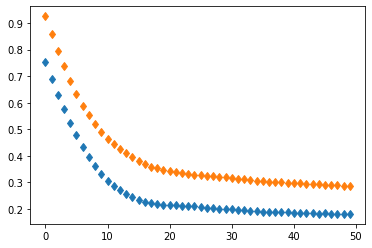

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(results['train_rmse'], 'd')
plt.plot(results['val_rmse'], 'd')
# plt.title('Model accuracy')
# plt.ylabel('RMSE')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [18]:
mcpredd=np.array(mc_predictions)
# print(np.squeeze(mcpredd[:,:,-1]).shape)
mc_pred = np.squeeze(mcpredd[:,:,-1])
np.std(mc_pred,axis=0)**2
    # mcpred = mcpredd[:,:,1]
# print(mcpred.shape, mcpred)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0.], dtype=float32)

In [19]:
mc_pred

array([[0.16201127, 0.16201127, 0.34821904, 0.39140153, 0.1273129 ,
        0.30697948, 0.17096372, 0.39140153, 0.33946478, 0.20873177,
        0.1273129 , 0.38495588, 0.29122227, 0.29328594, 0.09926216,
        0.30697948, 0.08654739, 0.16201127, 0.23381582],
       [0.16201127, 0.16201127, 0.34821904, 0.39140153, 0.1273129 ,
        0.30697948, 0.17096372, 0.39140153, 0.33946478, 0.20873177,
        0.1273129 , 0.38495588, 0.29122227, 0.29328594, 0.09926216,
        0.30697948, 0.08654739, 0.16201127, 0.23381582],
       [0.16201127, 0.16201127, 0.34821904, 0.39140153, 0.1273129 ,
        0.30697948, 0.17096372, 0.39140153, 0.33946478, 0.20873177,
        0.1273129 , 0.38495588, 0.29122227, 0.29328594, 0.09926216,
        0.30697948, 0.08654739, 0.16201127, 0.23381582],
       [0.16201127, 0.16201127, 0.34821904, 0.39140153, 0.1273129 ,
        0.30697948, 0.17096372, 0.39140153, 0.33946478, 0.20873177,
        0.1273129 , 0.38495588, 0.29122227, 0.29328594, 0.09926216,
        0.306

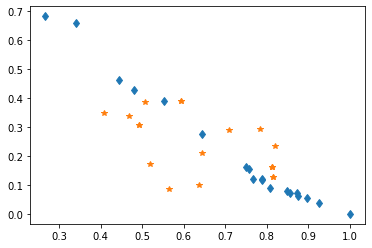

In [20]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(obs[:,0], obs[:,1], 'd')
plt.plot(pred[:,0], pred[:,1], '*')
# plt.title('Model accuracy')
# plt.ylabel('RMSE')
# plt.xlabel('Epoch')
# plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [27]:
save_obj(pred, "../results_BK_v2_cnstTest/pred_nn.dat")

Dict keys are: 
['train_rmse', 'val_rmse', 'test_rmse', 'PhyLoss']
Test RMSE:  0.0845550000667572 PhyLoss:  0.8637055499213082


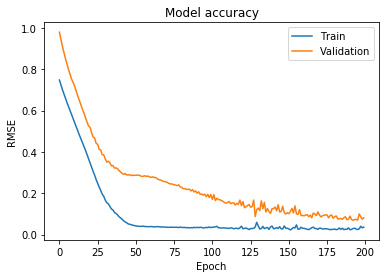

In [8]:
dict_keys = []

# get key and value 
print ("Dict keys are: ") 
for key, value in results.items(): 
    dict_keys.append(key)

print(dict_keys)
train_rmse = results[dict_keys[0]]
val_rmse = results[dict_keys[1]]
test_rmse = results[dict_keys[2]]
PhyLoss = results[dict_keys[3]]
print("Test RMSE: ",test_rmse,"PhyLoss: ", PhyLoss)


import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure()
plt.plot(train_rmse)
plt.plot(val_rmse)
plt.title('Model accuracy')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()